In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import os
os.environ['CXX'] = 'g++'

In [3]:
import pickle

import arviz
import numpy as np
import pandas as pd
import pymc3 as pm
from tqdm import tqdm

In [4]:
from IPython.display import display

In [5]:
import scipy.stats.distributions as dist

In [6]:
def get_quantile(density, bins, q):
    cumsums = np.cumsum(density * (bins[1:] - bins[:-1]))
    
    bin_index = np.nonzero(cumsums>=q)[0][0]
    # report center of bin
    return (bins[bin_index] + bins[bin_index+1]) * 0.5

In [7]:
def beta_a(mean, var):
    assert var < mean*(1-mean)
    
    return mean*(mean*(1-mean)/var-1)

def beta_b(mean, var):
    assert var < mean*(1-mean)
    
    return (1 - mean) * (mean*(1-mean)/var-1)

def beta_params(mean, var):
    return {
        'alpha': beta_a(mean, var),
        'beta': beta_b(mean, var),
    }

We need some helper functions to make plotting posterior distributions easier

In [14]:
def format_as_percent(x, round_to=0):
    return "{0:.{1:d}f}%".format(100 * x, round_to)

def plot_hpd(values, credible_interval=0.95, multimodal=False, ax=None, value_format='{:.02%}'):
    if ax is None:
        ax = plt.gca()
    
    if isinstance(value_format, str):
        value_format = lambda value, format_str=value_format: format_str.format(value)
    
    hpd_intervals = arviz.stats.hpd(
        values, credible_interval=credible_interval, multimodal=multimodal
    )  # type: np.ndarray
    
    plot_base = ax.get_ylim()[0]
    plot_height = ax.get_ylim()[1] - plot_base
    linewidth = 1
    ax_labelsize = 14
    round_to = 3

    for hpdi in np.atleast_2d(hpd_intervals):
        ax.plot(
            hpdi,
            (plot_base + plot_height * 0.02, plot_base + plot_height * 0.02),
            lw=linewidth * 2,
            color="k",
            solid_capstyle="butt",
        )
        ax.text(
            hpdi[0],
            plot_base + plot_height * 0.07,
            value_format(hpdi[0]),
            size=ax_labelsize,
            horizontalalignment="center",
        )
        ax.text(
            hpdi[1],
            plot_base + plot_height * 0.07,
            value_format(hpdi[1]),
            size=ax_labelsize,
            horizontalalignment="center",
        )
        ax.text(
            (hpdi[0] + hpdi[1]) / 2,
            plot_base + plot_height * 0.3,
            format_as_percent(credible_interval) + " HPD",
            size=ax_labelsize,
            horizontalalignment="center",
        )
    point_value = values.mean()
    point_text = 'mean='+value_format(point_value)
    
    ax.text(
        point_value,
        plot_height * 0.8,
        point_text,
        size=ax_labelsize,
        horizontalalignment="center",
    )

In [9]:
def plot_german_infected(values, ax=None):
    if ax is None:
        ax = plt.gca()
    
    values = np.asarray(values)
    ax.hist(values, bins=1000)
    ax.set_xlim(1e5, 5e6)
    plot_hpd(values, value_format=lambda value: '{:.02f}M'.format(value/1e6), ax=ax)
    
    #plt.xticks(np.arange(1e6, 10e6, step=1e6));
    ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda value, i: '{:.01f}M'.format(value/1e6)))
    ax.set_yticks([])
    sns.despine(left=True, ax=ax)
    
def plot_gangelt_infected(values, ax=None):
    if ax is None:
        ax = plt.gca()
    
    values = np.asarray(values)
    ax.hist(values, bins=100)
    ax.set_xlim(1000, 3000)
    plot_hpd(values,
             #value_format=lambda value: '{:d}'.format(value/1e6),
             #value_format='{:d}',
             value_format=lambda value: str(int(value)),
             ax=ax)
    
    #plt.xticks(np.arange(1e6, 10e6, step=1e6));
    #ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda value, i: '{:.01f}M'.format(value/1e6)))
    ax.set_yticks([])
    sns.despine(left=True, ax=ax)

def plot_infection_fatality_rate(values, ax=None, show_hpd=True, xlim=(0, 0.015)):
    if ax is None:
        ax = plt.gca()
    
    values = np.asarray(values)
    
    arviz.plot_kde(values, ax=ax, textsize=14)
    if show_hpd:
        plot_hpd(values, value_format=lambda value: '{:.02%}'.format(value), ax=ax)
    
    ax.set_xlim(xlim)
    
    #plt.xticks(np.arange(1e6, 10e6, step=1e6));
    ax.set_xticks([0.005, 0.01])
    ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda value, i: '{:.02%}'.format(value)))
    ax.set_yticks([])
    sns.despine(left=True, ax=ax)
    
    
def plot_infection_fatality_rate_prior(values, ax=None, show_hpd=True):
    if ax is None:
        ax = plt.gca()
    
    values = np.asarray(values)
    
    arviz.plot_kde(values, ax=ax, textsize=14)
    if show_hpd:
        plot_hpd(values, value_format=lambda value: '{:.02%}'.format(value), ax=ax)
    
    #ax.set_xlim(0, 0.4)
    ax.set_xlim(0, 1.0)
    
    #plt.xticks(np.arange(1e6, 10e6, step=1e6));
    #ax.set_xticks([0.005, 0.01])
    ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda value, i: '{:.00%}'.format(value)))
    ax.set_yticks([])
    sns.despine(left=True, ax=ax)
    
    
def plot_infection_rate(values, ax=None):
    if ax is None:
        ax = plt.gca()
    
    values = np.asarray(values)
    
    arviz.plot_kde(values, ax=ax, textsize=14)
    ax.set_xlim(0.1, 0.25)
    plot_hpd(values, value_format=lambda value: '{:.02%}'.format(value), ax=ax)
    
    #plt.xticks(np.arange(1e6, 10e6, step=1e6));
    ax.set_xticks([0.1, 0.15, 0.2])
    ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda value, i: '{:.02%}'.format(value)))
    ax.set_yticks([])
    sns.despine(left=True, ax=ax)

# First Model:

We first infer a posterior over the infection fatality rate as follows:
We model the infection rate in gangelt as a beta distribution that captures the uncertainty that the study authors report.
The number of infections in Gangelt is then modelled as binomially distributed depending on the infection rate eand the (fixed) number of people in Gangled.
The number of fatalities is modelled as bionomially distributed depending on the infection fatality rate and the number of infections with a weak beta prior in the infection fatality rate.

After computing the posterior over the infection fatality rate, we model the infections in germany as a negative binomial distribution depending on the infection fatality rate that and the number of deaths in germany.

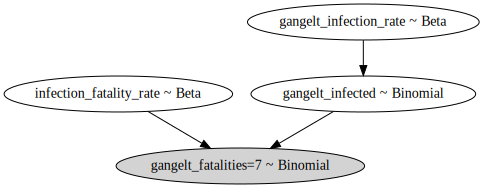

In [22]:
with pm.Model() as model:
    # compute beta parameters from estimate and CI in paper: 0.1553 [0.1231, 0.1896].
    gangelt_infection_rate_mean = 0.1553
    gangelt_infection_rate_sd = (0.1896-0.1231)/4  # the paper states a 95%CI of [0.1231, 0.1896]
    gangelt_infection_a = beta_a(mean=gangelt_infection_rate_mean, var=gangelt_infection_rate_sd**2)
    gangelt_infection_b = beta_b(mean=gangelt_infection_rate_mean, var=gangelt_infection_rate_sd**2)
    
    gangelt_infection_rate = pm.Beta(alpha=gangelt_infection_a, beta=gangelt_infection_b, name='gangelt_infection_rate')
    
    total_population = 12597
    gangelt_infected = pm.Binomial(n=total_population, p=gangelt_infection_rate, name='gangelt_infected')
    
    ifr_prior_alpha = 0.3
    ifr_prior_beta = 30
    infection_fatality_rate = pm.Beta(alpha=ifr_prior_alpha, beta=ifr_prior_beta, name='infection_fatality_rate')
    gangelt_fatalities = pm.Binomial(n=gangelt_infected, p=infection_fatality_rate, name='gangelt_fatalities=7', observed=7)    

display(pm.model_graph.model_to_graphviz(model))

### Inspecting the priors

let's have a look into the priors to see whether they align with our intuitions and are not too narrow

In [23]:
if not os.path.isfile('model1_prior.pydat'):
    with model:
        prior = pm.sample_prior_predictive(samples=100000)
    with open('model1_prior.pydat', 'wb') as f:
        pickle.dump(prior, f)
else:
    prior = pickle.load(open('model1_prior.pydat', 'rb'))

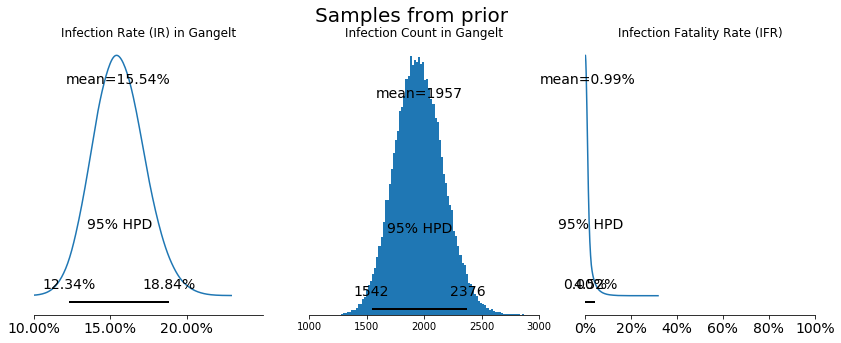

In [24]:
f, axs = plt.subplots(1, 3, figsize=(14, 5))

plot_infection_rate(prior['gangelt_infection_rate'], ax=axs[0])
plot_gangelt_infected(prior['gangelt_infected'], ax=axs[1])
plot_infection_fatality_rate_prior(prior['infection_fatality_rate'], ax=axs[2])


axs[0].set_title('Infection Rate (IR) in Gangelt')
axs[2].set_title('Infection Fatality Rate (IFR)')
axs[1].set_title('Infection Count in Gangelt')

f.suptitle('Samples from prior', fontsize=20);

## Sampling the posterior

In [25]:
if not os.path.isfile('model1_posterior.pydat'):
    with model:
        posterior = pm.sample(draws=1000000)
    with open('model1_posterior.pydat', 'wb') as f:
        pickle.dump(posterior, f)
else:
    posterior = pickle.load(open('model1_posterior.pydat', 'rb'))

In [55]:
pm.summary(posterior)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
gangelt_infected,1951.838,212.169,1551.000,2347.000,1.457,1.032,21215.0,21127.0,21322.0,43690.0,1.0
gangelt_infection_rate,0.155,0.017,0.124,0.186,0.000,0.000,21714.0,21629.0,21822.0,45426.0,1.0
infection_fatality_rate,0.004,0.001,0.001,0.006,0.000,0.000,222896.0,222896.0,222468.0,575503.0,1.0


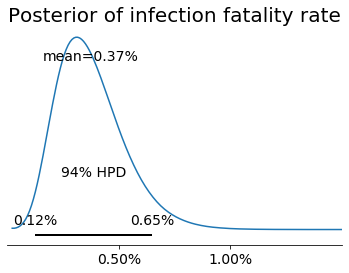

In [56]:
plot_infection_fatality_rate(posterior['infection_fatality_rate'])
plt.title('Posterior of infection fatality rate', fontsize=20);

## Sampling the number of infections in Germany with a negative binomial distribution

In [26]:
if os.path.isfile('model1_german_infected.pydat'):
    german_infected = pickle.load(open('model1_german_infected.pydat', 'rb'))
else:
    with model:
        german_infected = [dist.nbinom(n=6575, p=p).rvs() for p in tqdm(posterior['infection_fatality_rate'])]
    with open('model1_german_infected.pydat', 'wb') as f:
        pickle.dump(german_infected, f)

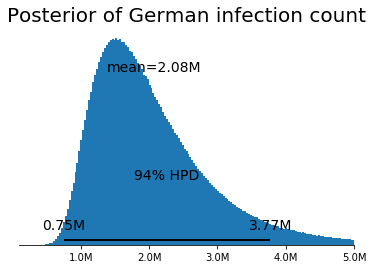

In [58]:
plot_german_infected(german_infected)
plt.title('Posterior of German infection count', fontsize=20);

Main results are done. Insert discussion here

In [59]:
# add with new number of fatalities in Germany

If we use the current number of fatalities in Germany (7824, taken from the [Robert Koch Institut](https://experience.arcgis.com/experience/478220a4c454480e823b17327b2bf1d4) as of 2020-05-15), we can get an updated estimate of the number of infections in Germany:

In [60]:
if os.path.isfile('model1_german_infected_updated.pydat'):
    german_infected_updated = pickle.load(open('model1_german_infected_updated.pydat', 'rb'))
else:
    german_infected_updated = [dist.nbinom(n=7824, p=p).rvs() for p in (posterior['infection_fatality_rate'])]

    with open('model1_german_infected_updated.pydat', 'wb') as f:
        pickle.dump(german_infected_updated, f)

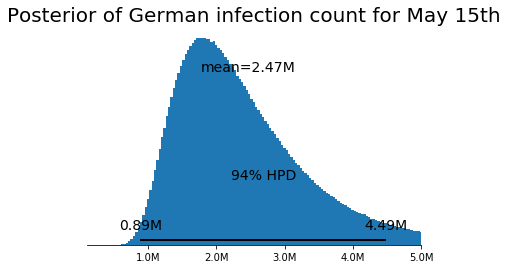

In [61]:
plot_german_infected(german_infected_updated)
plt.title('Posterior of German infection count for May 15th', fontsize=20);

# Appendix

# Checking different priors

Here we test how much the prior over the IFR matters for the results.

### Wider prior in IFR

In this model we still use a beta prior over the IFR, but with mean 0.1 and std 0.2 (instead of 0.1). So this pior is less informed.

0.3 30
0.009900990099009901 0.017697277361464415
0.0


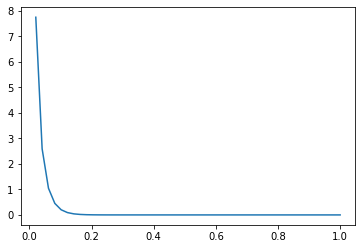

In [18]:
xs = np.linspace(0, 1)
#mean = 0.01
#sd = 0.02
#a = beta_a(mean=mean, var=sd**2)
#b = beta_b(mean=mean, var=sd**2)
a = 0.3
b = 30
print(a, b)
d = dist.beta(a=a, b=b)
print(d.mean(), d.std())
ys = d.pdf(xs)
print(ys[-1])
plt.plot(xs, ys)

In [41]:
with pm.Model() as model_1:
    gangelt_infection_rate = pm.Beta(alpha=gangelt_infection_a, beta=gangelt_infection_b, name='gangelt_infection_rate')
    
    total_population = 12597
    gangelt_infected = pm.Binomial(n=total_population, p=gangelt_infection_rate, name='gangelt_infected')
    
    infection_fatality_rate = pm.Beta(alpha=0.8, beta=7, name='infection_fatality_rate')
    gangelt_fatalities = pm.Binomial(n=gangelt_infected, p=infection_fatality_rate, name='gangelt_fatalities=7', observed=7)    

if os.path.isfile('model1_1.pydat'):
    tmp = pickle.load(open('model1_1.pydat', 'rb'))
    prior_1 = tmp['prior']
    posterior_1 = tmp['posterior']
    german_infected_1 = tmp['german_infected']
else:
    with model_1:
        prior_1 = pm.sample_prior_predictive(samples=50000)
        posterior_1 = pm.sample(draws=100000)
        german_infected_1 = [dist.nbinom(n=6575, p=p).rvs() for p in (posterior_1['infection_fatality_rate'])]

        with open('model1_1.pydat', 'wb') as f:
            pickle.dump({'prior': prior_1, 'posterior': posterior_1, 'german_infected': german_infected_1}, f)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [infection_fatality_rate, gangelt_infection_rate]
>Metropolis: [gangelt_infected]
Sampling 4 chains, 0 divergences: 100%|██████████| 402000/402000 [02:16<00:00, 2940.24draws/s]
The acceptance probability does not match the target. It is 0.8863550312849746, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 10% for some parameters.


In [30]:
with pm.Model() as model_2:
    gangelt_infection_rate = pm.Beta(alpha=gangelt_infection_a, beta=gangelt_infection_b, name='gangelt_infection_rate')
    
    total_population = 12597
    gangelt_infected = pm.Binomial(n=total_population, p=gangelt_infection_rate, name='gangelt_infected')
    
    infection_fatality_rate = pm.Beta(alpha=1, beta=3, name='infection_fatality_rate')
    gangelt_fatalities = pm.Binomial(n=gangelt_infected, p=infection_fatality_rate, name='gangelt_fatalities=7', observed=7)    

if os.path.isfile('model1_2.pydat'):
    tmp = pickle.load(open('model1_2.pydat', 'rb'))
    prior_2 = tmp['prior']
    posterior_2 = tmp['posterior']
    german_infected_2 = tmp['german_infected']
else:
    with model_2:
        prior_2 = pm.sample_prior_predictive(samples=50000)
        posterior_2 = pm.sample(draws=1000000)
        german_infected_2 = [dist.nbinom(n=6575, p=p).rvs() for p in (posterior_2['infection_fatality_rate'])]

        with open('model1_2.pydat', 'wb') as f:
            pickle.dump({'prior': prior_2, 'posterior': posterior_2, 'german_infected': german_infected_2}, f)

### Uniform  prior in IFR

In [31]:
with pm.Model() as model_3:
    gangelt_infection_rate = pm.Beta(alpha=gangelt_infection_a, beta=gangelt_infection_b, name='gangelt_infection_rate')
    
    total_population = 12597
    gangelt_infected = pm.Binomial(n=total_population, p=gangelt_infection_rate, name='gangelt_infected')
    
    infection_fatality_rate = pm.Uniform(lower=0,upper=1, name='infection_fatality_rate')
    gangelt_fatalities = pm.Binomial(n=gangelt_infected, p=infection_fatality_rate, name='gangelt_fatalities=7', observed=7)    

if os.path.isfile('model1_3.pydat'):
    tmp = pickle.load(open('model1_3.pydat', 'rb'))
    prior_3 = tmp['prior']
    posterior_3 = tmp['posterior']
    german_infected_3 = tmp['german_infected']
else:
    with model_3:
        prior_3 = pm.sample_prior_predictive(samples=500000)
        posterior_3 = pm.sample(draws=100000)
        german_infected_3 = [dist.nbinom(n=6575, p=p).rvs() for p in (posterior_3['infection_fatality_rate'])]

        with open('model1_3.pydat', 'wb') as f:
            pickle.dump({'prior': prior_3, 'posterior': posterior_3, 'german_infected': german_infected_3}, f)

# TODO

- state that prior shows samples
- plot from 0-100
- write alpha and beta into plot

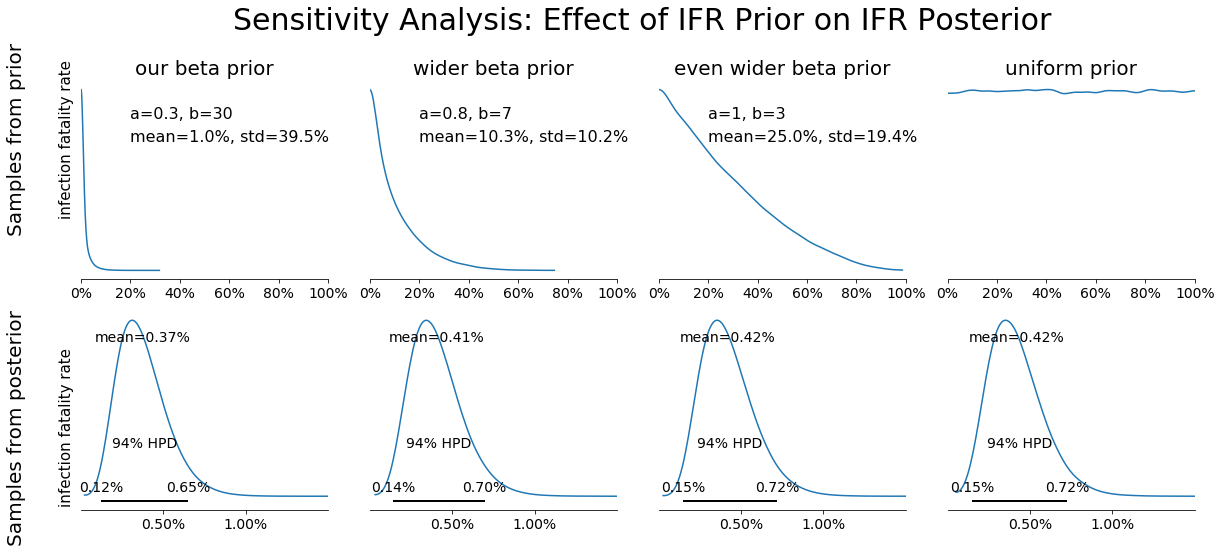

In [63]:
rows = 2
cols = 4
width = 4.5
height = 4

f, axs = plt.subplots(rows, cols, figsize=(cols*width, rows*height))
models = [
    (prior, posterior),
    (prior_1, posterior_1),
    (prior_2, posterior_2),
    (prior_3, posterior_3),
    #(prior_3, posterior_3, german_infected_3),
]

for model_index, (_prior, _posterior) in enumerate(models):
    plot_infection_fatality_rate_prior(_prior['infection_fatality_rate'], ax=axs[0, model_index], show_hpd=False)
    plot_infection_fatality_rate(_posterior['infection_fatality_rate'], ax=axs[1, model_index])
    
plt.tight_layout(rect=(0.05, 0.05, 0.95, 0.87))

axs[0, 0].set_title('our beta prior', fontsize=20)
axs[0, 1].set_title('wider beta prior', fontsize=20)
axs[0, 2].set_title('even wider beta prior', fontsize=20)
axs[0, 3].set_title('uniform prior', fontsize=20)

axs[0, 0].text(0.2, .8*axs[0, 0].get_ylim()[1], f'a={ifr_prior_alpha}, b={ifr_prior_beta}', fontsize=16)
axs[0, 0].text(0.2, .68*axs[0, 0].get_ylim()[1], 'mean={:.01%}, std={:.01%}'.format(
    dist.beta(a=ifr_prior_alpha, b=ifr_prior_beta).mean(),
    dist.beta(a=ifr_prior_alpha, b=ifr_prior_alpha).std(),
), fontsize=16)

axs[0, 1].text(0.2, .8*axs[0, 1].get_ylim()[1], f'a=0.8, b=7', fontsize=16)
axs[0, 1].text(0.2, .68*axs[0, 1].get_ylim()[1], 'mean={:.01%}, std={:.01%}'.format(
    dist.beta(a=0.8, b=7).mean(),
    dist.beta(a=0.8, b=7).std(),
), fontsize=16)


axs[0, 2].text(0.2, .8*axs[0, 2].get_ylim()[1], 'a=1, b=3', fontsize=16)
axs[0, 2].text(0.2, .68*axs[0, 2].get_ylim()[1], 'mean={:.01%}, std={:.01%}'.format(
    dist.beta(a=1, b=3).mean(),
    dist.beta(a=1, b=3).std(),
), fontsize=16)

plt.gcf().text(0.05, 1.5/rows, 'infection fatality rate', rotation=90, verticalalignment='center', fontsize=15)
plt.gcf().text(0.05, 0.5/rows, 'infection fatality rate', rotation=90, verticalalignment='center', fontsize=15)
plt.gcf().text(0.01, 1.5/rows, 'Samples from prior', rotation=90, verticalalignment='center', fontsize=20)
plt.gcf().text(0.01, 0.5/rows, 'Samples from posterior', rotation=90, verticalalignment='center', fontsize=20)

f.suptitle("Sensitivity Analysis: Effect of IFR Prior on IFR Posterior", fontsize=30);

# Extrapolation

In [63]:
if os.path.isfile('model1_german_infected.pydat'):
    german_infected = pickle.load(open('model1_german_infected.pydat', 'rb'))
else:
    with model:
        german_infected = [dist.nbinom(n=6575, p=p).rvs() for p in tqdm(posterior['infection_fatality_rate'])]
    with open('model1_german_infected.pydat', 'wb') as f:
        pickle.dump(german_infected, f)

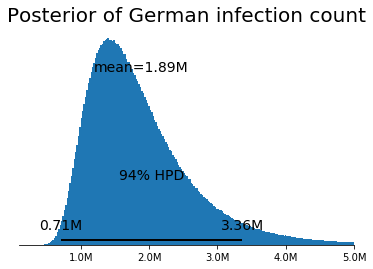

In [64]:
plot_german_infected(german_infected)
plt.title('Posterior of German infection count', fontsize=20);

In [65]:
if os.path.isfile('model1_german_infected_updated.pydat'):
    german_infected_updated = pickle.load(open('model1_german_infected_updated.pydat', 'rb'))
else:
    german_infected_updated = [dist.nbinom(n=7824, p=p).rvs() for p in (posterior['infection_fatality_rate'])]

    with open('model1_german_infected_updated.pydat', 'wb') as f:
        pickle.dump(german_infected_updated, f)

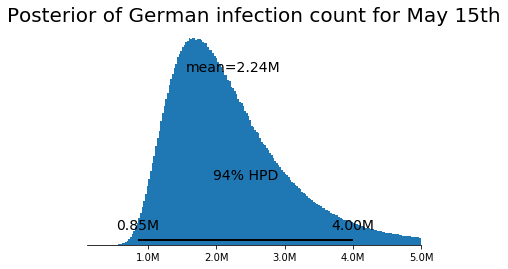

In [66]:
plot_german_infected(german_infected_updated)
plt.title('Posterior of German infection count for May 15th', fontsize=20);

# Appendix

In [46]:
ifr_prior_beta

3

In [11]:
if os.path.isfile('model1_fatality_analysis.pydata'):
    fatality_models = pickle.load(open('model1_fatality_analysis.pydata', 'rb'))
else:
    fatality_models = {}

# Run the model for different numbers of fatalities
for fatalities in [5, 6, 7, 8, 9]:
    print(fatalities)
    if fatalities in fatality_models:
        continue
    with pm.Model() as model:
        # the infection rate is given as 0.1553 [0.1231, 0.1896].
        gangelt_infection_rate = pm.Beta(**beta_params(mean=0.1553, var=((0.1896-0.1231)/4)**2), name='gangelt_infection_rate')

        total_population = 12597
        gangelt_infected = pm.Binomial(n=total_population, p=gangelt_infection_rate, name='gangelt_infected')

        infection_fatality_rate = pm.Beta(alpha=ifr_prior_alpha, beta=ifr_prior_beta, name='infection_fatality_rate')
        gangelt_fatalities = pm.Binomial(n=gangelt_infected, p=infection_fatality_rate, name='gangelt_fatalities', observed=fatalities)
    
        _prior = pm.sample_prior_predictive(samples=50000)
        _posterior = pm.sample(draws=100000)
        
    _german_infected = [dist.nbinom(n=6575, p=p).rvs() for p in tqdm(_posterior['infection_fatality_rate'])]
    fatality_models[fatalities] = {
        'model': model,
        'prior': _prior,
        'posterior': _posterior,
        'german_infected': _german_infected
    }
    
    with open('model1_fatality_analysis.pydata', 'wb') as f:
        pickle.dump(fatality_models, f)

5
6
7
8


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [infection_fatality_rate, gangelt_infection_rate]
>Metropolis: [gangelt_infected]
Sampling 4 chains, 0 divergences: 100%|██████████| 402000/402000 [02:18<00:00, 2895.98draws/s]
The acceptance probability does not match the target. It is 0.9002614493843352, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8840929277980284, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8924102149098069, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 10% for some parameters.
100%|██████████| 400000/400000 [04:28<00:00, 1489.29it/s]


9


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [infection_fatality_rate, gangelt_infection_rate]
>Metropolis: [gangelt_infected]
Sampling 4 chains, 2 divergences: 100%|██████████| 402000/402000 [02:38<00:00, 2536.11draws/s]
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5472723899139329, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.5782468244502711, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 10% for some parameters.
100%|██████████| 400000/400000 [04:29<00:00, 1481.62it/s]


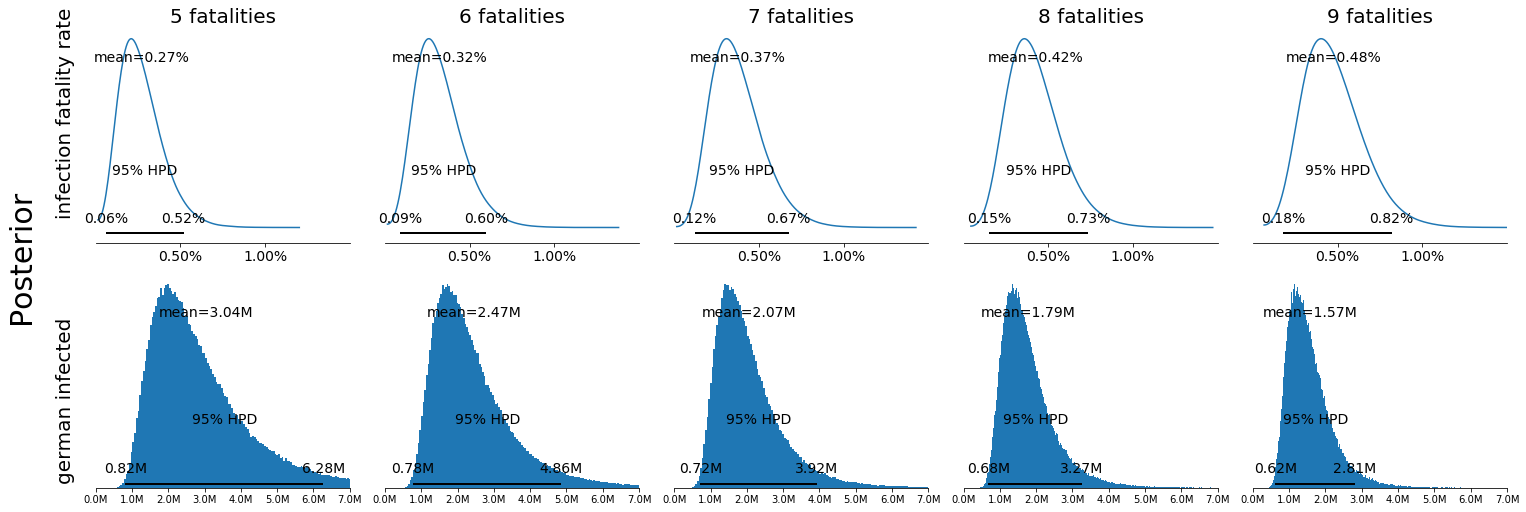

In [16]:
rows = 2
cols = 5
width = 4.5
height = 4

f, axs = plt.subplots(rows, cols, figsize=(cols*width, rows*height))

for model_index, (fatalities, data) in enumerate(fatality_models.items()):
    plot_infection_fatality_rate(data['posterior']['infection_fatality_rate'], ax=axs[0, model_index])
    plot_german_infected(data['german_infected'], ax=axs[1, model_index])
    axs[1, model_index].set_xlim(0, 7e6)
    axs[0, model_index].set_title(f'{fatalities} fatalities', fontsize=20)

plt.tight_layout(rect=(0.05, 0.05, 0.95, 0.95))

plt.gcf().text(0.04, 1.5/rows, 'infection fatality rate', rotation=90, verticalalignment='center', fontsize=20)
plt.gcf().text(0.04, 0.5/rows, 'german infected', rotation=90, verticalalignment='center', fontsize=20)
plt.gcf().text(0.01, 1/rows, 'Posterior', rotation=90, verticalalignment='center', fontsize=30);

In [27]:
# normal model

In [28]:
with pm.Model() as model_normal_ir_prior:
    # compute normal parameters from estimate and CI in paper: 0.1553 [0.1231, 0.1896].
    gangelt_infection_rate_mean = 0.1553
    gangelt_infection_rate_sd = (0.1896-0.1231)/4  # the paper states a 95%CI of [0.1231, 0.1896]
    
    gangelt_infection_rate = pm.Normal(mu=gangelt_infection_rate_mean, sd=gangelt_infection_rate_sd, name='gangelt_infection_rate')
    
    total_population = 12597
    gangelt_infected = pm.Binomial(n=total_population, p=gangelt_infection_rate, name='gangelt_infected')
    
    infection_fatality_rate = pm.Beta(alpha=ifr_prior_alpha, beta=ifr_prior_beta, name='infection_fatality_rate')
    gangelt_fatalities = pm.Binomial(n=gangelt_infected, p=infection_fatality_rate, name='gangelt_fatalities=7', observed=7)    

if os.path.isfile('model1_normal_ir_prior.pydat'):
    tmp = pickle.load(open('model1_normal_ir_prior.pydat', 'rb'))
    prior_normal = tmp['prior']
    posterior_normal = tmp['posterior']
    german_infected_normal = tmp['german_infected']
else:
    with model_normal_ir_prior:
        prior_normal = pm.sample_prior_predictive(samples=50000)
        posterior_normal = pm.sample(draws=100000)
        german_infected_normal = [dist.nbinom(n=6575, p=p).rvs() for p in (posterior_normal['infection_fatality_rate'])]

        with open('model1_normal_ir_prior.pydat', 'wb') as f:
            pickle.dump({'prior': prior_normal, 'posterior': posterior_normal, 'german_infected': german_infected_normal}, f)

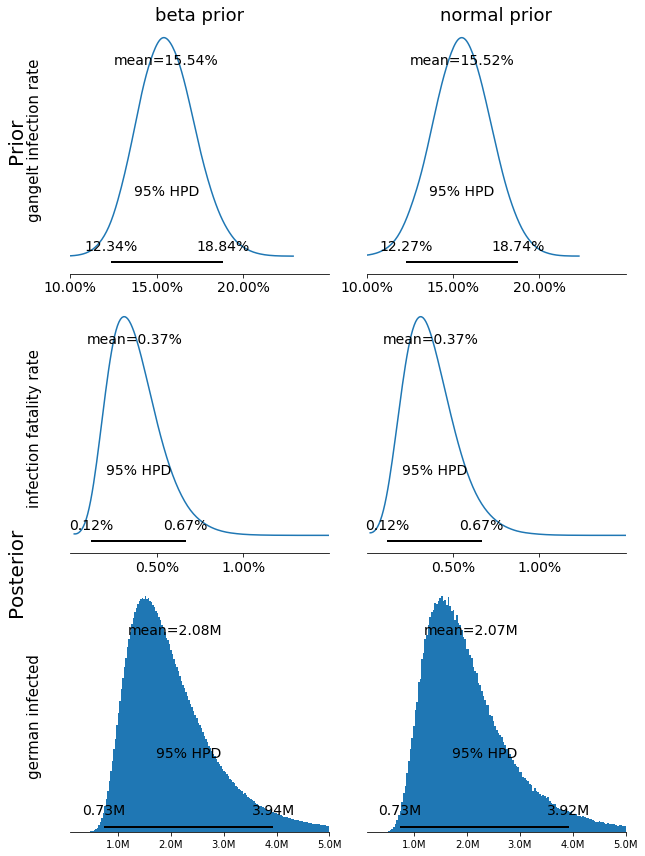

In [30]:
rows = 3
cols = 2
width = 4.5
height = 4

f, axs = plt.subplots(rows, cols, figsize=(cols*width, rows*height))

models = [
    (prior, posterior, german_infected),
    (prior_normal, posterior_normal, german_infected_normal),
]

for model_index, (_prior, _posterior, _german_infected) in enumerate(models):

    plot_infection_rate(_prior['gangelt_infection_rate'], ax=axs[0, model_index])
    plot_infection_fatality_rate(_posterior['infection_fatality_rate'], ax=axs[1, model_index])
    plot_german_infected(_german_infected, ax=axs[2, model_index])
    
axs[0, 0].set_title('beta prior', fontsize=18)
axs[0, 1].set_title('normal prior', fontsize=18)

plt.tight_layout(rect=(0.05, 0, 1, 1))
plt.gcf().text(0.04, 2.5/rows, 'gangelt infection rate', rotation=90, verticalalignment='center', fontsize=15)
plt.gcf().text(0.04, 1.5/rows, 'infection fatality rate', rotation=90, verticalalignment='center', fontsize=15)
plt.gcf().text(0.04, 0.5/rows, 'german infected', rotation=90, verticalalignment='center', fontsize=15)
plt.gcf().text(0.01, 2.5/rows, 'Prior', rotation=90, verticalalignment='center', fontsize=20)
plt.gcf().text(0.01, 1/rows, 'Posterior', rotation=90, verticalalignment='center', fontsize=20);

TODO: add new number of deaths. Discuss why this makes sense. Maybe even timeline?

# How much can we constrain what we already knew?

In [389]:
with pm.Model() as model_constraining:
    # the infection rate is given as 0.1553 [0.1231, 0.1896].
    gangelt_infection_rate = pm.Beta(**beta_params(mean=0.1553, var=((0.1896-0.1231)/4)**2), name='gangelt_infection_rate')
    
    total_population = 12597
    gangelt_infected = pm.Binomial(n=total_population, p=gangelt_infection_rate, name='gangelt_infected')
    
    infection_fatality_rate = pm.Beta(**beta_params(mean=0.0045, var=0.0023**2), name='infection_fatality_rate')
    gangelt_fatalities = pm.Binomial(n=gangelt_infected, p=infection_fatality_rate, name='gangelt_fatalities=7', observed=7)    

if False: #os.path.isfile('model1_constraining.pydat'):
    tmp = pickle.load(open('model1_constraining.pydat', 'rb'))
    prior_constraining = tmp['prior']
    posterior_constraining = tmp['posterior']
    german_infected_constraining = tmp['german_infected']
else:
    with model_constraining:
        prior_constraining = pm.sample_prior_predictive(samples=50000)
        posterior_constraining = pm.sample(draws=100000)
        german_infected_constraining = [dist.nbinom(n=6575, p=p).rvs() for p in (posterior_constraining['infection_fatality_rate'])]

        with open('model1_constraining.pydat', 'wb') as f:
            pickle.dump({'prior': prior_constraining, 'posterior': posterior_constraining, 'german_infected': german_infected_constraining}, f)


Sampling 4 chains, 0 divergences: 100%|██████████| 402000/402000 [03:08<00:00, 2135.99draws/s][A
The acceptance probability does not match the target. It is 0.6414443404872737, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.6352233865744097, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 10% for some parameters.


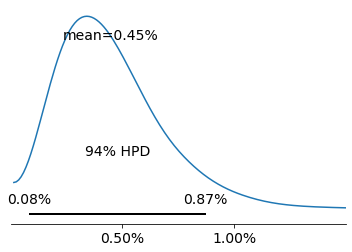

In [390]:
plot_infection_fatality_rate(prior_constraining['infection_fatality_rate'])

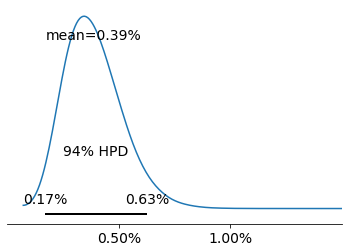

In [391]:
plot_infection_fatality_rate(posterior_constraining['infection_fatality_rate'])

So if we expected the infection fatality rate prior to the Heinsberg study to be between 0.08% and 0.87% (which should be roughly what was infered from previous data), the data in Heinsberg can reduce the uncertainty to the inferval between 0.17% and 0.63%.